<a href="https://colab.research.google.com/github/vanikanoria/DeepLearning_Fall2021/blob/main/DeepLearningProject_notebook2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hyperparameter tuning for Generative Adversarial Networks: Notebook 2 of 2

In [2]:
#import required libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (BatchNormalization, 
                                     LeakyReLU, 
                                     Reshape, 
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import pandas as pd

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

#link - https://github.com/zalandoresearch/fashion-mnist
#The data is already been sorted in to training and testing for us

(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

#Create a small list so we can read the label as well
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandle', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


4431872/4422102 [==============================] - 0s 0us/step


In [4]:
train_data, train_labels

(array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        ...,
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],

In [5]:
test_data = test_data.reshape(test_data.shape[0], 28, 28, 1).astype('float32')

In [6]:
train_data = train_data.reshape(train_data.shape[0], 28, 28, 1).astype('float32') 

In [7]:
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [8]:
# Normalize the images to [-1, 1] by using 127.5 as the mean
test_data = (test_data - 127.5) / 127.5 

In [9]:
train_data = train_data.reshape(train_data.shape[0], 28, 28, 1).astype('float32')
train_data = (train_data - 127.5) / 127.5

In [10]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [11]:
# Batch and shuffle the training data
train_dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [12]:
# Batch and shuffle the test data
test_dataset = tf.data.Dataset.from_tensor_slices(test_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [13]:
def make_generator_model(num_Conv2Dneurons_1, num_Conv2Dneurons_2):
    model = tf.keras.Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(Conv2DTranspose(num_Conv2Dneurons_1, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, num_Conv2Dneurons_1)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(num_Conv2Dneurons_2, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, num_Conv2Dneurons_2)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [14]:
generator = make_generator_model(128, 64)

In [15]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

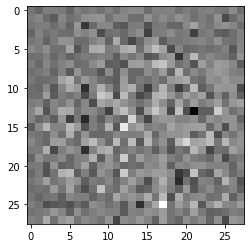

In [16]:
noise = tf.random.normal([1, 100]) #Generate 100 random floating numbers
generated_image = generator(noise, training=False)
# Visualize the generated sample
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [17]:
def make_discriminator_model(num_Conv2Dneurons_1, num_Conv2Dneurons_2, dropout_rate):
    model = tf.keras.Sequential()
    
    model.add(Conv2D(num_Conv2Dneurons_2, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(num_Conv2Dneurons_1, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(1))

    return model

In [18]:
discriminator = make_discriminator_model(128,64,0.3)

In [19]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [22]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [23]:
#create the required variables
EPOCHS = 60
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
num_examples_to_generate = 16
noise_dim = 100
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [24]:
# tf.function annotation causes the function 
# to be "compiled" as part of the training
@tf.function # Compiles a function into a callable TensorFlow graph. (deprecated arguments)

def train_step(images):
  
    # 1 - Create a random noise to feed it into the model
    # for the image generation
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    # 2 - Generate images and calculate loss values
    # GradientTape method records operations for automatic differentiation.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # 3 - Calculate gradients using loss values and model variables
    # "gradient" method computes the gradient using 
    # operations recorded in context of this tape (gen_tape and disc_tape).

    gradients_of_generator = gen_tape.gradient(gen_loss, 
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                discriminator.trainable_variables)
    
    # 4 - Process  Gradients and Run the Optimizer
    # "apply_gradients" method processes aggregated gradients. 

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [25]:
import time
from IPython import display # A command shell for interactive computing in Python.

def train(dataset, epochs, dropout_rate):
  # A. For each epoch, do the following:
  for epoch in range(epochs):
    start = time.time()
    # 1 - For each batch of the epoch, 
    for image_batch in dataset:
      # 1.a - run the custom "train_step" function
      # we just declared above
      train_step(image_batch)

    # 2 - Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1, epoch,
                             seed, dropout_rate*100)

    # 3 - Save the model every 5 epochs as 
    # a checkpoint, which we will use later
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # 4 - Print out the completed epoch no. and the time spent
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # B. Generate a final image after the training is completed
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,epochs,
                           seed, dropout_rate*100)


In [26]:
def generate_and_save_images(model, epoch, num_epochs, test_input, dropout_perc):
  # 1 - Generate images
  predictions = model(test_input, training=False)
  # 2 - Plot the generated images if epoch = num_epochs
  if epoch == num_epochs:
    for i in range(predictions.shape[0]):
        fig = plt.figure(figsize=(1,1))
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        plt.savefig('image_{}_at_epoch_{:04d}_dropout_{}.png'.format(epoch, i,dropout_perc))
  # 3 - To save the generated images:
  #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  #plt.show()

# Start the training

Number of neurons in layer 1: 64
Dropout rates = 0.1, 0.3

Dropout rate: 0.1

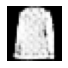

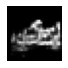

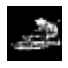

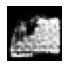

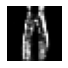

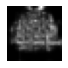

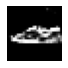

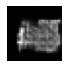

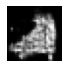

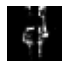

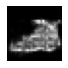

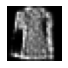

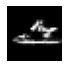

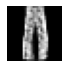

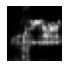

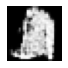

In [33]:
generator = make_generator_model(64, 64)
discriminator = make_discriminator_model(64,64, 0.1)
train(train_dataset, EPOCHS, 0.1)

In [36]:
from PIL import Image
dropout_rate = 0.1*100
# get images 

img_list = []

for i in range(16):
  img= Image.open('image_{}_at_epoch_{:04d}_dropout_{}.png'.format(EPOCHS, i,10.0))
  img_list.append(img)

# get width and height
w, h = img_list[1].size


# create big empty image with place for images
new_image = Image.new('RGB', (w*4, h*4))

counter = 0
for i in range(4):
  for j in range(4):
    new_image.paste(img_list[counter],(w*i,h*j))
    counter+=1

# save it
new_image.save('combined_image_64_dropout_{}.png'.format(dropout_rate))

Dropout rate: 0.3

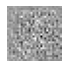

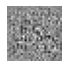

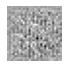

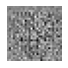

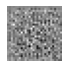

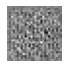

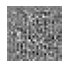

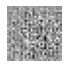

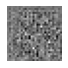

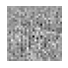

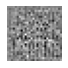

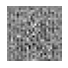

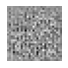

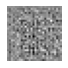

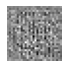

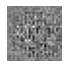

In [34]:
generator = make_generator_model(64, 64)
discriminator = make_discriminator_model(64,64, 0.3)
train(train_dataset, EPOCHS, 0.3)

In [37]:
from PIL import Image
dropout_rate = 0.3*100
# get images 

img_list = []

for i in range(16):
  img= Image.open('image_{}_at_epoch_{:04d}_dropout_{}.png'.format(EPOCHS, i,30.0))
  img_list.append(img)

# get width and height
w, h = img_list[1].size


# create big empty image with place for images
new_image = Image.new('RGB', (w*4, h*4))

counter = 0
for i in range(4):
  for j in range(4):
    new_image.paste(img_list[counter],(w*i,h*j))
    counter+=1

# save it
new_image.save('combined_image_dropout_{}.png'.format(dropout_rate))

Dropout rate: 0.5

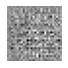

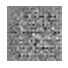

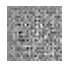

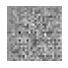

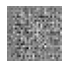

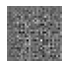

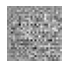

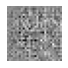

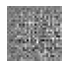

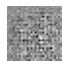

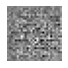

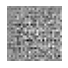

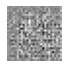

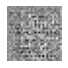

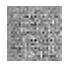

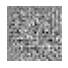

In [38]:
generator = make_generator_model(64, 64)
discriminator = make_discriminator_model(64,64, 0.5)
train(train_dataset, EPOCHS, 0.5)

In [39]:
from PIL import Image
dropout_rate = 0.5*100
# get images 

img_list = []

for i in range(16):
  img= Image.open('image_{}_at_epoch_{:04d}_dropout_{}.png'.format(EPOCHS, i,dropout_rate))
  img_list.append(img)

# get width and height
w, h = img_list[1].size


# create big empty image with place for images
new_image = Image.new('RGB', (w*4, h*4))

counter = 0
for i in range(4):
  for j in range(4):
    new_image.paste(img_list[counter],(w*i,h*j))
    counter+=1

# save it
new_image.save('combined_image_64_dropout_{}.png'.format(dropout_rate))

Number of neurons in layer 1: 256
Dropout rates = 0.1, 0.3

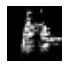

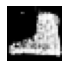

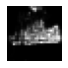

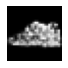

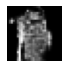

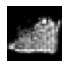

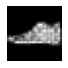

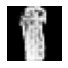

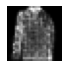

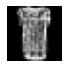

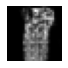

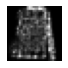

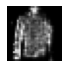

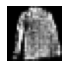

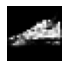

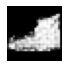

In [27]:
generator = make_generator_model(256, 64)
discriminator = make_discriminator_model(256, 64, 0.1)
train(train_dataset, EPOCHS, 0.1)

In [28]:
from PIL import Image
dropout_rate = 0.1*100
# get images 

img_list = []

for i in range(16):
  img= Image.open('image_{}_at_epoch_{:04d}_dropout_{}.png'.format(EPOCHS, i,dropout_rate))
  img_list.append(img)

# get width and height
w, h = img_list[1].size


# create big empty image with place for images
new_image = Image.new('RGB', (w*4, h*4))

counter = 0
for i in range(4):
  for j in range(4):
    new_image.paste(img_list[counter],(w*i,h*j))
    counter+=1

# save it
new_image.save('combined_image_256_dropout_{}.png'.format(dropout_rate))

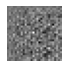

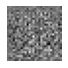

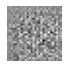

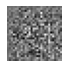

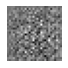

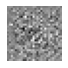

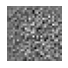

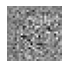

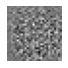

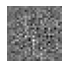

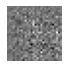

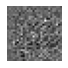

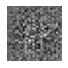

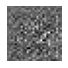

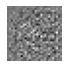

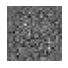

In [29]:
generator = make_generator_model(256, 64)
discriminator = make_discriminator_model(256, 64, 0.3)
train(train_dataset, EPOCHS, 0.3)

In [30]:
from PIL import Image
dropout_rate = 0.3*100
# get images 

img_list = []

for i in range(16):
  img= Image.open('image_{}_at_epoch_{:04d}_dropout_{}.png'.format(EPOCHS, i,dropout_rate))
  img_list.append(img)

# get width and height
w, h = img_list[1].size


# create big empty image with place for images
new_image = Image.new('RGB', (w*4, h*4))

counter = 0
for i in range(4):
  for j in range(4):
    new_image.paste(img_list[counter],(w*i,h*j))
    counter+=1

# save it
new_image.save('combined_image_256_dropout_{}.png'.format(dropout_rate))